# Train with BasicPitch's Loss

The first round of basicamt training must be completed.

In [1]:
import torch
import os
import tqdm

import sys
sys.path.append("../..")
sys.path.append("../../..")
from utils.checkpoint import save_ckpt_template as save_ckpt, load_ckpt_template as load_ckpt
from basicpitch.loss import basicpitch_loss
lossfn = basicpitch_loss(weighted=True, positive_weight=0.95)

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True   # 加速卷积计算
else:
    device = torch.device('cpu')

print(device)

cuda


In [2]:
device = "cuda:1"

In [3]:
from data.septimbre.data import Instruments
dataset = Instruments(
    folder = '../../../data/septimbre/multi_large_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=18, shuffle=True, pin_memory=True, num_workers=4)
print("训练集大小: ", len(dataset))
input, label = dataset[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

val = Instruments(
    folder = '../../../data/septimbre/multi_medium_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
valloader = torch.utils.data.DataLoader(val, batch_size=18, shuffle=False, pin_memory=True, num_workers=4)
print("测试集大小: ", len(val))
input, label = val[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

# CQT配置
from model.config import CONFIG
s_per_frame = CONFIG.s_per_frame

_model = None

训练集大小:  8316
输入大小:  torch.Size([1, 1, 230400])
输出大小:  torch.Size([1, 84, 900])
测试集大小:  720
输入大小:  torch.Size([1, 1, 230400])
输出大小:  torch.Size([1, 84, 900])


In [4]:
# 从分体开始
from basicamt import BasicAMT, BasicAMT_all
_model = BasicAMT().to(device)
optimizer = torch.optim.AdamW(_model.parameters(), lr=2e-4)
checkpoint_path = "basicamt.pth"

# 加载最佳模型
states = load_ckpt(_model, optimizer, "../../" + "best_" + checkpoint_path)
if not states:
    print("No best checkpoint loaded.")

Checkpoint loaded from '../../best_basicamt.pth'
epoch: 5, loss: 7480.021999755859, min_loss: 8222.143308105467


In [5]:
from basicamt import BasicAMT, BasicAMT_all
if _model is not None:
    model = BasicAMT_all(CONFIG.CQT, _model.state_dict(), CQTlearnable = False).to(device)
    print("model initialized from BasicAMT")
else:
    model = BasicAMT_all(CONFIG.CQT, CQTlearnable = False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)  # follow the origin paper
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, threshold=1e-3)
checkpoint_path = "basicamt_all_BCE.pth"
loss_path = "basicamt_all_BCE.loss.txt"
min_loss = float('inf')
epoch_now = 0

model initialized from BasicAMT


In [6]:
# 加载上一轮模型参数
states = load_ckpt(model, optimizer, checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No checkpoint loaded. Training from scratch.")

Checkpoint file 'basicamt_all_BCE.pth' does not exist.
No checkpoint loaded. Training from scratch.


In [7]:
model = torch.compile(model)

In [8]:
epoch_total = 45
stage_save_interval = 40    # save checkpoint every $stage_save_interval$ epochs

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)    # input: (batch, mix, 2, time)
        target = target.to(device)  # target: (batch, mix, 7 * 12, 660)

        # 由于basicamt的目标没有分离音色，因此mix仅仅是数据增强的手段
        if dataset.mix > 1:
            mixed = torch.mean(input, dim=1, keepdim=False)  # 混合后的CQT
            midi_mixed, _ = target.max(dim=-3, keepdim=False)
        else:
            mixed = input.squeeze(dim=1)
            midi_mixed = target.squeeze(dim=1)

        mixed = mixed + torch.randn_like(mixed) * 0.005   # 加入噪声 经过听觉和可视化觉得0.005是一个合适的值
        # midi_mixed: (batch, 7 * 12, 660)

        onset, note = model(mixed)
        # onset & note: (batch, 7 * 12, 660)
        # loss = BasicAMT.loss(onset, note, midi_mixed)
        loss = lossfn["note"]((midi_mixed == 1).float(), note) + lossfn["onset"]((midi_mixed > 1.5).float(), onset)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        model.clampK()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            if val.mix > 1:
                mixed = torch.sum(input, dim=1, keepdim=False)
                midi_mixed, _ = target.max(dim=-3, keepdim=False)
            else:
                mixed = input.squeeze(dim=1)
                midi_mixed = target.squeeze(dim=1)

            onset, note = model(mixed)
            loss = lossfn["note"]((midi_mixed == 1).float(), note) + lossfn["onset"]((midi_mixed > 1.5).float(), onset)
            val_loss += loss.item()

        val_loss /= len(valloader)
    
    final_loss = val_loss * 0.85 + train_loss * 0.15
    schedular.step(final_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_ckpt(epoch, model, min_loss, final_loss, optimizer, checkpoint_filename)
    if final_loss < min_loss:
        min_loss = final_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch

100%|██████████| 40/40 [00:03<00:00, 10.34it/s]


====> Epoch: 1 Average train loss: 0.7556; Average val loss: 0.7027


100%|██████████| 40/40 [00:01<00:00, 24.25it/s]


====> Epoch: 2 Average train loss: 0.6930; Average val loss: 0.6859


100%|██████████| 40/40 [00:01<00:00, 23.96it/s]


====> Epoch: 3 Average train loss: 0.6823; Average val loss: 0.6824


100%|██████████| 40/40 [00:01<00:00, 24.07it/s]


====> Epoch: 4 Average train loss: 0.6796; Average val loss: 0.6814


100%|██████████| 40/40 [00:01<00:00, 24.18it/s]


====> Epoch: 5 Average train loss: 0.6781; Average val loss: 0.6796


100%|██████████| 40/40 [00:01<00:00, 24.07it/s]


====> Epoch: 6 Average train loss: 0.6771; Average val loss: 0.6802


100%|██████████| 40/40 [00:01<00:00, 24.10it/s]


====> Epoch: 7 Average train loss: 0.6761; Average val loss: 0.6769


100%|██████████| 40/40 [00:01<00:00, 24.17it/s]


====> Epoch: 8 Average train loss: 0.6755; Average val loss: 0.6777


100%|██████████| 40/40 [00:01<00:00, 24.23it/s]


====> Epoch: 9 Average train loss: 0.6749; Average val loss: 0.6762


100%|██████████| 40/40 [00:01<00:00, 23.97it/s]


====> Epoch: 10 Average train loss: 0.6745; Average val loss: 0.6757


100%|██████████| 40/40 [00:01<00:00, 24.16it/s]


====> Epoch: 11 Average train loss: 0.6739; Average val loss: 0.6754


100%|██████████| 40/40 [00:01<00:00, 24.06it/s]


====> Epoch: 12 Average train loss: 0.6737; Average val loss: 0.6747


100%|██████████| 40/40 [00:01<00:00, 23.92it/s]


====> Epoch: 13 Average train loss: 0.6732; Average val loss: 0.6752


100%|██████████| 40/40 [00:01<00:00, 24.06it/s]


====> Epoch: 14 Average train loss: 0.6729; Average val loss: 0.6762


100%|██████████| 40/40 [00:01<00:00, 24.20it/s]


====> Epoch: 15 Average train loss: 0.6718; Average val loss: 0.6733


100%|██████████| 40/40 [00:01<00:00, 24.21it/s]


====> Epoch: 16 Average train loss: 0.6715; Average val loss: 0.6730


100%|██████████| 40/40 [00:01<00:00, 24.11it/s]


====> Epoch: 17 Average train loss: 0.6714; Average val loss: 0.6728


100%|██████████| 40/40 [00:01<00:00, 24.01it/s]


====> Epoch: 18 Average train loss: 0.6714; Average val loss: 0.6724


100%|██████████| 40/40 [00:01<00:00, 24.03it/s]


====> Epoch: 19 Average train loss: 0.6713; Average val loss: 0.6728


100%|██████████| 40/40 [00:01<00:00, 23.90it/s]


====> Epoch: 20 Average train loss: 0.6711; Average val loss: 0.6725


100%|██████████| 40/40 [00:01<00:00, 24.10it/s]


====> Epoch: 21 Average train loss: 0.6710; Average val loss: 0.6724


100%|██████████| 40/40 [00:01<00:00, 24.21it/s]


====> Epoch: 22 Average train loss: 0.6706; Average val loss: 0.6724


100%|██████████| 40/40 [00:01<00:00, 24.21it/s]


====> Epoch: 23 Average train loss: 0.6705; Average val loss: 0.6719


100%|██████████| 40/40 [00:01<00:00, 24.16it/s]


====> Epoch: 24 Average train loss: 0.6705; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.10it/s]


====> Epoch: 25 Average train loss: 0.6703; Average val loss: 0.6719


100%|██████████| 40/40 [00:01<00:00, 24.22it/s]


====> Epoch: 26 Average train loss: 0.6703; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.08it/s]


====> Epoch: 27 Average train loss: 0.6703; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.01it/s]


====> Epoch: 28 Average train loss: 0.6702; Average val loss: 0.6719


100%|██████████| 40/40 [00:01<00:00, 24.07it/s]


====> Epoch: 29 Average train loss: 0.6702; Average val loss: 0.6719


100%|██████████| 40/40 [00:01<00:00, 24.05it/s]


====> Epoch: 30 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.07it/s]


====> Epoch: 31 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.19it/s]


====> Epoch: 32 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.01it/s]


====> Epoch: 33 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.19it/s]


====> Epoch: 34 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 23.95it/s]


====> Epoch: 35 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.11it/s]


====> Epoch: 36 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.00it/s]


====> Epoch: 37 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.22it/s]


====> Epoch: 38 Average train loss: 0.6702; Average val loss: 0.6721


100%|██████████| 40/40 [00:01<00:00, 23.85it/s]


====> Epoch: 39 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.12it/s]


====> Epoch: 40 Average train loss: 0.6701; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 23.78it/s]


====> Epoch: 41 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 24.12it/s]


====> Epoch: 42 Average train loss: 0.6702; Average val loss: 0.6719


100%|██████████| 40/40 [00:01<00:00, 24.14it/s]


====> Epoch: 43 Average train loss: 0.6702; Average val loss: 0.6720


100%|██████████| 40/40 [00:01<00:00, 23.93it/s]

====> Epoch: 44 Average train loss: 0.6702; Average val loss: 0.6719


In [9]:
model.cqt.cqt_kernels.requires_grad

False

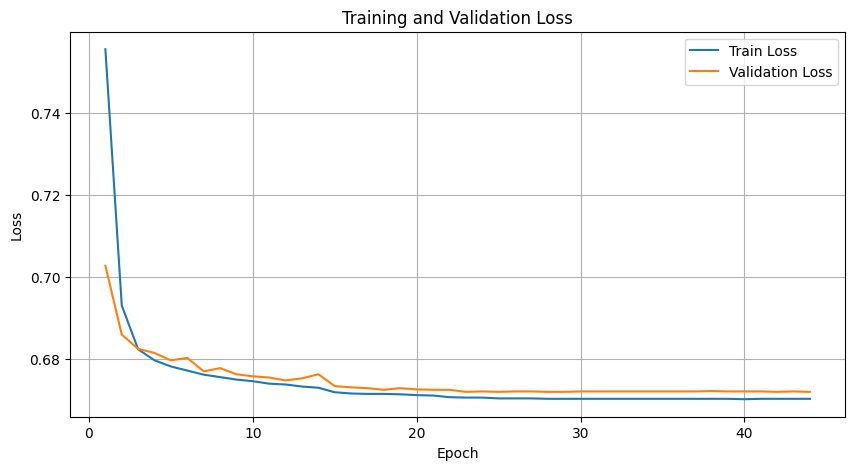

In [10]:
# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

epochs = []
train_losses = []
val_losses = []

with open(loss_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        epoch = int(parts[0].split(':')[0])
        train_loss = float(parts[1].split(': ')[1])
        val_loss = float(parts[2].split(': ')[1])
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 测试模型

In [11]:
# 加载最佳模型
states = load_ckpt(model, optimizer, "best_" + checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt_all_BCE.pth'
epoch: 42, loss: 0.6716313093774892, min_loss: 0.6716464398365902


In [12]:
# 切换到cpu 因为benchmark会导致初次运行时间长
device = torch.device('cpu')
model = model.to(device)
torch.backends.cudnn.benchmark = False

Sample rate: 44100
Channels: 2
Sample width: 2
Number of frames: 186112
Duration (s): 4.220226757369614
data num: 372224
torch.Size([1, 2, 93056])


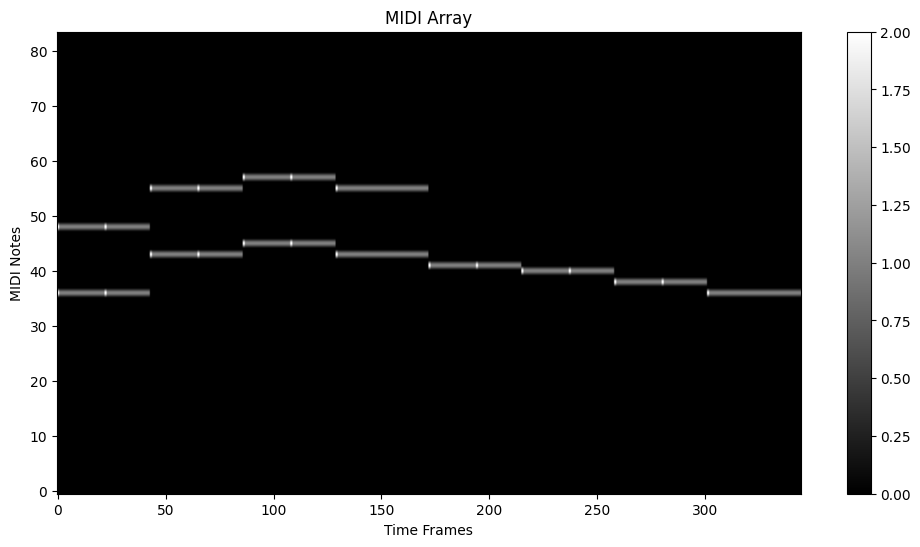

(84, 345)


In [13]:
# 读取音频
import torchaudio
from utils.midiarray import midi2numpy
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np

test_wave_path = "../../../data/inferMusic/piano_short.wav"
# test_wave_path = "../../../data/inferMusic/孤独な巡礼simple.wav"
waveInfo(test_wave_path)

waveform, sample_rate = torchaudio.load(test_wave_path, normalize=True)
waveform = waveform.unsqueeze(0)
waveform = model.cqt.down2sample(waveform)
print(waveform.shape)

test_midi_path = test_wave_path.replace('.wav', '.mid')
s_per_frame = 256 / 22050
midi_array = midi2numpy(test_midi_path, s_per_frame)
plt.figure(figsize=(12, 6))
plt.imshow(midi_array, aspect='auto', origin='lower', cmap='gray')
plt.colorbar()
plt.title('MIDI Array')
plt.xlabel('Time Frames')
plt.ylabel('MIDI Notes')
plt.show()
print(midi_array.shape)

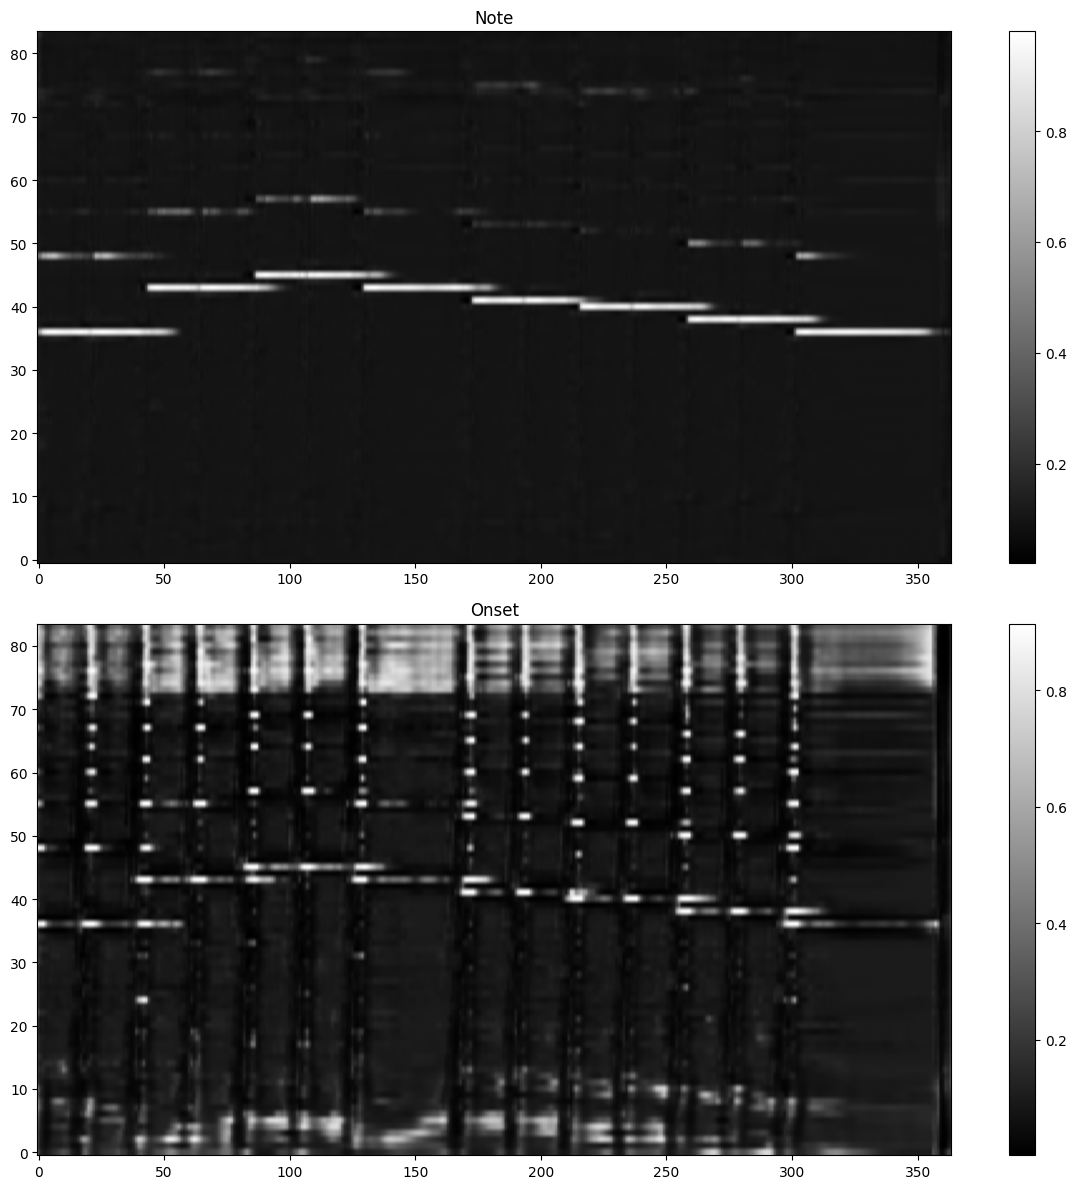

In [14]:
model.eval()
with torch.no_grad():
    onset, note = model(waveform)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 1, 1)
    plt.title('Note')
    plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.title('Onset')
    plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [15]:
torch.save(model, "basicamt_model_BCE.pth")

In [16]:
plt.imsave("basicamt_BCE_infer_note.png", note, cmap='gray', origin='lower')
plt.imsave("basicamt_BCE_infer_onset.png", onset, cmap='gray', origin='lower')
np.savez("basicamt_BCE_infer_output.npz", note=note, onset=onset)